# OCMR Tutorial

This is a tutorial to read the k-space from OCMR datasets. Please intall 'ismrmrd-python' and 'ismrmrd-python-tools' before running it. The tutorial includes a brief instrucion to setup ISMRMRD libraries and an example of how to use ismrmrd readwrapper 'read_ocmr.py'. The outputs of the example are the results for 'us_0165_pt_1_5T.h5', which is a prosective undersampled patient dataset (6-slices LAX stack), collected on Siemens 1.5T Sola scanner. The code is tested using 'Anaconda3->Jupyter Lab 1.2.6'. 

## 1. Install ISMRMRD libraries
### Install ismrmrd-python https://github.com/ismrmrd/ismrmrd-python
 To install the requirements of ismrmrd-python, please open 'Anaconda Promt' and run the following commands:
 
 conda install h5py nose six ;      conda install -c conda-forge pyxb

In [ ]:
# Only needed for the first run (Requirements: h5py==2.9.0   nose==1.3.7  numpy==1.16.3  PyXB==1.2.6 six==1.12.0 )
%cd PATH_OF_ismrmrd-python-master
!python setup.py install

### Install ismrmrd-python-tools https://github.com/ismrmrd/ismrmrd-python-tools 

In [ ]:
# Only needed for the first run
%cd PATH_OF_ismrmrd-python-tools-master
!python setup.py install

## 2. An example of reading k-space from OCMR data

Dowload data from https://ocmr.osu.edu. Download "read_ocmr.py" and "exmaple_ocmr.ipynb" from https://github.com/MRIOSU/OCMR/tree/master/Python. Make sure ismrmrd-python and ismrmrd-python tools have been installed sucessfully and the Jupyter kernal is restarted after the installation.
### (1). Import the required libraries

In [1]:
%cd PATH_OF_OCMR_Tutorial
# import required library
import numpy as np
import matplotlib.pyplot as plt
import math

from ismrmrdtools import show, transform

# import ReadWrapper
import read_ocmr as read

### (2). Read k-space from *.h5 file and display the scan parameters
 Modify 'filename' as needed. Once the data is read using readwrapper (read_ismrmrd.py), it yields two outputs. The first one is k-space,
  whose dimension is fixed as:  [ kx, ky, kz ,coil, phase, set, slice, repetation, average ].
  Anothor one is'param', which includes some basic parameters of the scan, such as field of view (FOV, mm), temporal resolution (TRes, ms), flip angle (fligAngle_deg, degress). Note, the readout dimension includes a factor of two oversampling, leading to FOV(1) that is twice the value selected on the scanner.

In [2]:
# Load the data, display size of kData and scan parmaters
filename = './data/us_0165_pt_1_5T.h5'
kData,param = read.read_ocmr(filename);

print('Dimension of kData: ', kData.shape)
print('Scan paramters:')
import pprint; pprint.pprint(param)

Imaging acquisition starts acq  32
Dimension of kData:  (352, 126, 1, 24, 30, 1, 6, 1, 1)
Scan paramters:
{'FOV': [800.0, 306.220093, 7.0],
 'TE': '[1.19]',
 'TI': '[300.0]',
 'TRes': '[49.32]',
 'echo_spacing': '[2.74]',
 'flipAngle_deg': '[80.0]',
 'kspace_dim': {'kx ky kz coil phase set slice rep avg'},
 'sequence_type': 'SSFP'}


### (3). Display the sampling pattern
Modify 'slc_idx' as needed. The default value is the central slice. As shown in the following figure, this dataset is prospective undersampled with pseudo-random
sampling and assymetry echo on.

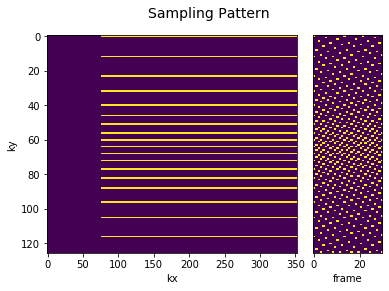

In [3]:
# Show the sampling Pattern
# kData_tmp-[kx,ky,kz,coil,phase,set,slice,rep], samp-[kx,ky,kz,phase,set,slice,rep]
dim_kData = kData.shape; CH = dim_kData[3]; SLC = dim_kData[6]; 
kData_tmp = np.mean(kData, axis = 8); # average the k-space if average > 1
samp = (abs(np.mean(kData_tmp, axis = 3)) > 0).astype(np.int) # kx ky kz phase set slice

slc_idx = math.floor(SLC/2);
fig1 = plt.figure(1); fig1.suptitle("Sampling Pattern", fontsize=14);
plt.subplot2grid((1, 8), (0, 0), colspan=6);
tmp = plt.imshow(np.transpose(np.squeeze(samp[:,:,0,0,0,slc_idx])), aspect= 'auto');
plt.xlabel('kx');plt.ylabel('ky'); tmp.set_clim(0.0,1.0) # ky by kx
plt.subplot2grid((1, 9), (0, 7),colspan=2);
tmp = plt.imshow(np.squeeze(samp[int(dim_kData[0]/2),:,0,:,0,slc_idx]),aspect= 'auto'); 
plt.xlabel('frame');plt.yticks([]); tmp.set_clim(0.0, 1.0) # ky by frame

### (4). Display the time averaged image
Time averaged image of the central slice, where the coil images are combined using SOS(sum of square.)

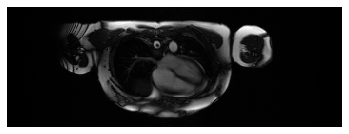

In [4]:
# Average the k-sapce along phase(time) dimension
kData_sl = kData_tmp[:,:,:,:,:,:,slc_idx,0];
samp_avg =  np.repeat(np.sum(samp[:,:,:,:,:,slc_idx,0],3), CH, axis=3) + np.finfo(float).eps
kData_sl_avg = np.divide(np.squeeze(np.sum(kData_sl,4)), np.squeeze(samp_avg));

im_avg = transform.transform_kspace_to_image(kData_sl_avg, [0,1]); # IFFT (2D image)
im = np.sqrt(np.sum(np.abs(im_avg) ** 2, 2)) # Sum of Square
fig2 = plt.figure(1); plt.imshow(np.transpose(im), cmap = 'gray'); plt.axis('off'); # Show the image